# Loop through subjects to find representative TFR and Trace figures

In [1]:
import os
# import mne
import sys
from pathlib import Path
import random
from tabulate import tabulate
sys.path.append('/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/')
from eeg_toolkit import utils, preprocess
import eeg_toolkit.functional_connectivity as fc
from glob import glob
import mne
from mne.time_frequency import tfr_morlet
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import scipy.io as sio
import seaborn as sns
from mne.time_frequency import AverageTFRArray, EpochsTFRArray, tfr_array_morlet

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [2]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
# sl_method = 'dSPM'
sl_method = 'MNE'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Representative TFR"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset
save_path = fc_subset_path
os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Manually enter age/sex matched subjects

In [4]:
# All CP and HC subs
sub_ids_CP = [  
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    '045',
    '046',
    '052', 
    '020',  
    '021',  
    '023',  
    '029',  
    '037',  
    '041',  
    '042',  
    '044',  
    '048',  
    '049',  
    '050',  
    '056' 
]

sub_ids_HC = [
    'C10',  
    'C11',  
    'C12',  
    'C13',  
    'C14',  
    'C15',  
    'C16',  
    'C17',  
    'C18',  
    'C19',  
    'C2.',  
    'C24',  
    'C25',  
    'C26',  
    'C27',  
    'C3.',  
    'C6.',  
    'C7.',  
    'C9.'  
]
  
# CP Subs with widespread pain
sub_ids_WSP = [
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    '045',
    '046',
    '052',
]

# CP Subs with localized pain
sub_ids_LP = [  
    '020',  
    '021',  
    '023',  
    '029',  
    '044',  
    '037',  
    '041',  
    '042',  
    '048',  
    '049',  
    '050',  
    '056'  
]  

sub_ids = sub_ids_CP + sub_ids_HC

# keep only unique
sub_ids = list(set(sub_ids))

### Low Back Pain Laterality

In [5]:
left_pain_ids = [
    '016',
    '017',
    '018',
    '019',
    '020',
    '023',
    '024',
    '025',
    '027',
    '028',
    '029',
    '030',
    '032',
    '033',
    '036',
    '038',
    '045',
    '052',
    '054',
    '055',
    '057',
    '058',
]

right_pain_ids = [
    '021',
    '026',
    '031',
    '037',
    '039',
    '043',
    '044',
    '046',
    '047',
    '048',
    '049',
    '050',
    '051',
    '053',
    '056',
]

bilateral_pain_ids = [
    '022',
    '034',
    '035',
    '040',
    '041',
    '042',
    '059',
]

# Randomly assign healthy subjects to left/right/bilateral pain
lst = sub_ids_HC
random.seed(42)
left_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in left_pain_ids]  

# Randomly assign 8 elements to right and remove them from lst  
right_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in right_pain_ids]  
  
# Assign the remaining elements to bilateral  
bilateral_pain_ids.extend(lst)  

In [6]:
for sub_ids, group in zip([sub_ids_CP, sub_ids_WSP, sub_ids_LP, sub_ids_HC],"CP WSP LP HC".split()):  
    print(f"\n{group}")  
    for sub_pain_ids, laterality in zip([left_pain_ids, right_pain_ids, bilateral_pain_ids],"Left Right Bilateral".split()):  
        print(f"{laterality} - {len(set(sub_ids) & set(sub_pain_ids))}")  
        print(set(sub_ids) & set(sub_pain_ids))  


CP
Left - 9
{'024', '029', '018', '052', '023', '045', '036', '020', '032'}
Right - 10
{'044', '031', '050', '021', '046', '056', '048', '037', '049', '039'}
Bilateral - 5
{'042', '022', '034', '040', '041'}

WSP
Left - 6
{'024', '018', '052', '045', '036', '032'}
Right - 3
{'046', '031', '039'}
Bilateral - 3
{'022', '040', '034'}

LP
Left - 3
{'029', '020', '023'}
Right - 7
{'044', '050', '056', '037', '021', '048', '049'}
Bilateral - 2
{'042', '041'}

HC
Left - 8
{'C18', 'C24', 'C11', 'C13', 'C12', 'C9.', 'C10', 'C17'}
Right - 8
{'C25', 'C7.', 'C26', 'C27', 'C15', 'C14', 'C3.', 'C6.'}
Bilateral - 3
{'C19', 'C16', 'C2.'}


In [7]:
# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

In [8]:
print(f"Chronics (all): {len(sub_ids_CP)}")
print([el for el in sub_ids_CP])
print(f"Chronics with widespread pain: {len(sub_ids_WSP)}")
print([el for el in sub_ids_WSP])
print(f"Chronics with localized pain: {len(sub_ids_LP)}")
print([sub for sub in sub_ids_LP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"\nTotal (Chronics + Controls): {len(sub_ids)}")


Chronics (all): 24
['018', '022', '024', '031', '032', '034', '036', '039', '040', '045', '046', '052', '020', '021', '023', '029', '037', '041', '042', '044', '048', '049', '050', '056']
Chronics with widespread pain: 12
['018', '022', '024', '031', '032', '034', '036', '039', '040', '045', '046', '052']
Chronics with localized pain: 12
['020', '021', '023', '029', '044', '037', '041', '042', '048', '049', '050', '056']
Controls: 19
['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2.', 'C24', 'C25', 'C26', 'C27', 'C3.', 'C6.', 'C7.', 'C9.']

Total (Chronics + Controls): 19


### Settings for conditions/bands/methods

In [9]:
# Settings

# Data properties
sfreq = 400  # Hz


### Define ROIs, frequency bands, conditions, and methods for FC

In [10]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
            #  # CONTROLS
            #  # lateral occipital
            #  'lateraloccipital-lh', # Left Visual Cortex
            #  'superiortemporal-lh', # Left Auditory Cortex
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
            #  # CONTROLS
            #  'lateraloccipital-rh', # Right Visual Cortex
            #  'superiortemporal-rh', # Right Auditory Cortex
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                # # Controls
                # "lOCC-lh", "aud-lh",
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh", 
                # # Controls
                # "lOCC-rh", "aud-rh"
               ]

####################################################################
# BANDS OF INTEREST
Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONDITIONS
conditions = [
    "Hand 256 mN",
    # "Back 32 mN",
    # 'Back LS',
    # "Back 256 mN",
    "Eyes Open",
    # "Eyes Closed",
]

### Iterate through subjects

In [11]:
sub_id = sub_ids_CP[0]

In [12]:
# Get epochs and stc from one subject
# this_sub_id = next(sub_id)
this_sub_id = sub_id

# Epochs
epo_fname = glob(f"{processed_data_path}/{this_sub_id}*epo.fif")[0]
epochs = mne.read_epochs(epo_fname)
# STC
stc_epo_fname = glob(f"{zscored_epochs_data_path}/{this_sub_id}_epochs.pkl")[0]
stc_epo = pickle.load(open(stc_epo_fname, 'rb'))
stc_epo = np.array(stc_epo)
print(f"\nEpochs stc shape: {stc_epo.shape}")
# Eyes Open STC
stc_eo_fname = glob(f"{EO_resting_data_path}/{this_sub_id}_eyes_open.pkl")
stc_eo = pickle.load(open(stc_eo_fname[0], 'rb'))
print(f"\nEyes Open stc shape: {np.array(stc_eo).shape}")

# Get stim labels from processed data folder
stim_fname = glob(f"{processed_data_path}/{this_sub_id}*stim_labels.mat")[0]
stim_labels = sio.loadmat(stim_fname)["stim_labels"][0]
print(f"\nStim labels shape: {stim_labels.shape}")

# Select just hand 256 mN condition (label=3)
stc_epo_array = stc_epo[stim_labels == 3]
print(f"\nSTC Hand 256 mN only shape: {stc_epo_array.shape}")

Reading /home/wanglab/Documents/George Kenefati/Chronic Low Back Pain Study/Code/Functional connectivity analysis/../../Data/Processed Data/018_preprocessed-epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated

Epochs stc shape: (73, 12, 2001)

Eyes Open stc shape: (12, 141299)

Stim labels shape: (73,)

STC Hand 256 mN only shape: (20, 12, 2001)


In [24]:
# Define parameters for the TFR computation
freqs = np.logspace(*np.log10([1, 100]), num=50)  # Define frequency range of interest
n_cycles = freqs / 2.  # Define the number of cycles in each frequency

In [25]:
# Construct Epochs info
info = mne.create_info(
    ch_names=roi_acronyms,
    sfreq=sfreq,
    ch_types="eeg",
)

Applying baseline correction (mode: zscore)


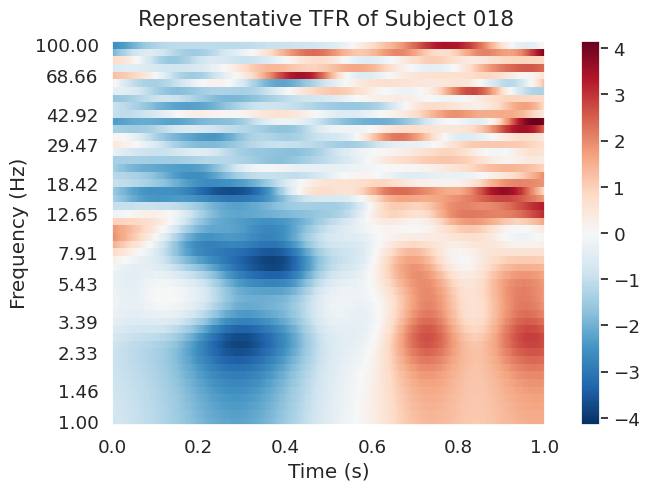

[<Figure size 640x480 with 2 Axes>]

In [28]:
power = tfr_array_morlet(
    stc_epo,
    sfreq=sfreq,
    freqs=freqs,
    n_cycles=n_cycles,
    output="avg_power",
    zero_mean=False,
)
# Put it into a TFR container for easy plotting
tfr = AverageTFRArray(
    info=info, 
    data=power, 
    times=epochs.times, 
    freqs=freqs, 
    nave=stc_epo.shape[0],
)

vmin, vmax = -3.0, 3.0  # Define our color limits.

tfr.plot(
    baseline=(-2.5, 0.0),
    tmin=0.0,
    tmax=1.0,
    picks=[0],
    mode="zscore",
    # vlim=(vmin, vmax),
    title=f"Representative TFR of Subject {this_sub_id}",
)